In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-18 03:12:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2021-04-18 03:12:16 (37.2 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



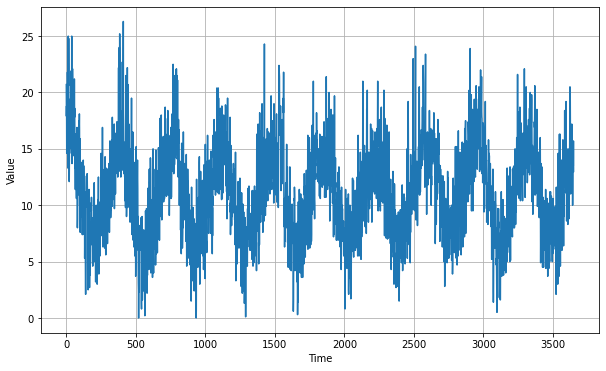

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step = 0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step += 1
        

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
np.shape(series)

(3650,)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, 
                               strides=1, padding='causal', 
                               activation='relu', input_shape=[None, 1]),
        tf.keras.layers.LSTM(16, return_sequences=True),
        tf.keras.layers.LSTM(8, return_sequences=True),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 6s 29ms/step - loss: 39.8956 - mae: 40.3956
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 39.6146 - mae: 40.1146
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 38.8021 - mae: 39.3021
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 37.7432 - mae: 38.2432
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 36.6644 - mae: 37.1644
Epoch 6/100
12/12 [==============================] - 0s 29ms/step - loss: 35.4521 - mae: 35.9521
Epoch 7/100
12/12 [==============================] - 0s 28ms/step - loss: 34.3080 - mae: 34.8080
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 32.6249 - mae: 33.1248
Epoch 9/100
12/12 [==============================] - 0s 26ms/step - loss: 30.8791 - mae: 31.3790
Epoch 10/100
12/12 [=====

(1e-08, 0.0001, 0.0, 60.0)

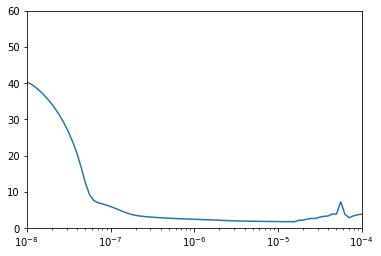

In [11]:


plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=85, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, 
                               strides=1, padding='causal', 
                               activation='relu', input_shape=[None, 1]),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
35/35 [==============================] - 2s 17ms/step - loss: 24.2381 - mae: 24.7340
Epoch 2/30
35/35 [==============================] - 1s 15ms/step - loss: 4.0807 - mae: 4.5584
Epoch 3/30
35/35 [==============================] - 1s 15ms/step - loss: 1.7237 - mae: 2.1731
Epoch 4/30
35/35 [==============================] - 1s 15ms/step - loss: 1.5577 - mae: 1.9997
Epoch 5/30
35/35 [==============================] - 1s 16ms/step - loss: 1.5424 - mae: 1.9822
Epoch 6/30
35/35 [==============================] - 1s 14ms/step - loss: 1.5299 - mae: 1.9703
Epoch 7/30
35/35 [==============================] - 1s 15ms/step - loss: 1.5234 - mae: 1.9630
Epoch 8/30
35/35 [==============================] - 1s 15ms/step - loss: 1.5203 - mae: 1.9608
Epoch 9/30
35/35 [==============================] - 1s 15ms/step - loss: 1.5220 - mae: 1.9618
Epoch 10/30
35/35 [==============================] - 1s 15ms/step - loss: 1.5096 - mae: 1.9506
Epoch 11/30
35/35 [==============================] - 1s 1

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

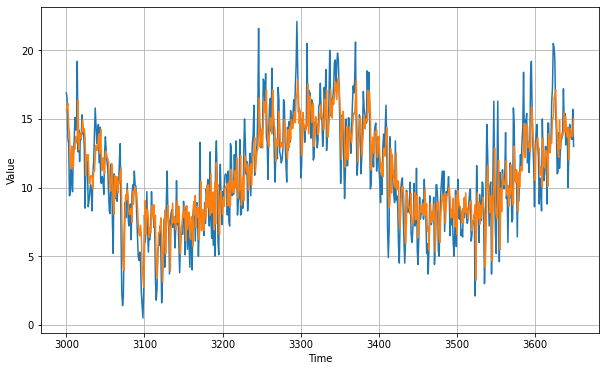

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7271888

In [16]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[15.644011  15.850285  16.12063   14.43536   14.038313  12.069929
 11.354605  13.021583  11.745499  11.477519  12.967568  12.8006935
 13.706321  13.256401  13.86506   16.379457  12.748546  13.895687
 13.664532  13.546077  14.051565  14.930773  14.065775  14.282206
 13.680285  10.888639  12.382162  12.01557   12.393216  10.480467
 10.294882  10.860274  10.850806  10.725923   9.905768  11.222897
 11.169729  12.109084  13.084179  12.703893  12.755453  13.687981
 13.909065  12.507349  14.257916  11.913494  11.235726  12.167395
 11.514757  11.036227  12.656489  12.598014  12.165228  12.122683
 11.89136   10.880307   9.99992    9.737498  11.754713  10.955039
  9.034399   8.035523  10.865096   9.288074  10.769189  10.787478
  9.600664  10.458914  10.345379  11.108298  11.436594   7.9561925
  4.8894916  4.1175785  3.943867   8.0520935  9.479336   9.110997
  9.822885   9.426091   8.236203   8.032403   8.30749    8.496193
  7.482351   9.742446   8.773813   9.812529  10.019622   9.538633
  9.6278